<h1><center>Identificación de Placas de Vehiculos Mediante Redes Neuronales Profundas.</center></h1>

<h2><center> Identificación de los números y letras de placas</center></h2>
 <h2><center>  Santiago Casas Ayala,David Velásquez Tafur </center></h2>
                        
<h3>Referencias</h3>

1. Imagenes tomadas de https://platerecognizer.com/number-plate-datasets/
2. Curso Topicos Avanzados de Estadistica - Por Alvaro Mauricio Montenegro, Universidad Nacional de Colombia, Diciembre 2019



In [1]:
#### Importe de Librerias a Usar
import tensorflow as tf 
from os import listdir
from os import makedirs
from shutil import copyfile
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import save
from numpy import random 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 
from matplotlib import pyplot
from matplotlib.image import imread
import cv2 as cv
from shutil import copyfile
from pandas import read_csv
from matplotlib import pyplot as plt
import sys
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Lo primero en lo que se enfocara es en el recorte de las imagenes puesto que las mismas poseen bastante ruido (Bordes, Letras Innecesarias,etc) y es necesario hacer un buen recorte que permita identificar más facilmente las letras y números que la componen para que sea mas sencillo para la maquina hacer la identificación de las letras y números. A continuación se mostrara una placa para que se comprenda cual es el problema que se tratara en el recorte.

In [28]:
path = '/home/smook/Unal/Machine Learning/Placas/proyecto_final' ## ingrese la ubicación de la carpeta del proyecto 

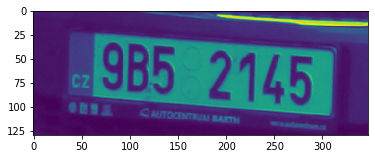

In [3]:
foldval = path +'/Data/datos/crop_m1'
img = cv.imread(foldval+'/I00000.png',0) 
plt.imshow(img)

 A continuación se definiran un cojunto de funciones que se usaran a lo largo del documento las cuales serviran para hacer el recorte de las imagenes y adicionalmente para crear los target de las letras o números que se recortaran de cada placa, esto debido a que por cada placa tendermos 6 números y 1 letra por lo tanto se crearan estas 7 imagenes que seran luego procesadas e introducidas a una maquina que nos indicara si estan bien recortadas o mal recortadas. 
 


In [24]:
############ Funciones Que se usaran durante el documento
def aver(h):
    return h.sum()/(h.size*255) 

def auto_canny(image, sigma=7):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1- sigma) * v))
    upper = int(min(255, (1 + sigma) * v))
    edged = cv.Canny(image, lower, upper)
 
    # return the edged image
    return edged
#### Recorta las imagenes de manera burda


def mycrop(photo,img1):
    imgcrop = []
    d = 5
    e = 5 
    me = []
    t = 0 
    for i in range(5):
        ver1 =  photo[e:300-e,d:d+15+d]
        t =   np.array( np.apply_along_axis(aver,1,ver1)).sum()
        ver2 =  photo[e:300-e,700-d-15:700-d] 
        t =   np.array( np.apply_along_axis(aver,1,ver2)).sum() +t
        ho1 =   photo[e:15+e,d:700-d]
        t =   np.array( np.apply_along_axis(aver,0,ho1)).sum() +t
        ho2 =   photo[300-e-10:300-e,d:700-d]
        t =   np.array( np.apply_along_axis(aver,0,ho2)).sum() +t
        me.append(t/4)
        d= d +10 
        e = e+ 5
    me = np.array(me)
    dd  = me.argmin()
    pruba = photo[10*dd:300-10*dd,15*dd:700-15*dd]
    pruba1 = img1[10*dd:300-10*dd,15*dd:700-15*dd]
    photo = pruba 
    photo  = cv.resize(pruba, (al,an) )
    photo1  = cv.resize(pruba1, (al,an) )
    x=np.array( np.apply_along_axis(aver,1,photo))
    xI = x[:20]
    xS = x[280:]
    ii = xI.argmin()
    s = xS.argmax()+280
    prueba = photo[ii:s,:]
    prueba1 = photo1[ii:s,:]
    y=np.array( np.apply_along_axis(aver,0,prueba))
    yI = y[:100]
    iiy= yI.argmin()
    pp = prueba[ii:s,iiy:]
    pp1 = prueba1[ii:s,iiy:]
   
    gray = cv.cvtColor(pp1,cv.COLOR_BGR2GRAY)
    thresh_inv = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,39,1)
    edges = auto_canny(thresh_inv)
    ctrs, _ = cv.findContours(edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv.boundingRect(ctr)[0])
    img_area = pp1.shape[0]*pp1.shape[1]
    stop = 0
    val = True
    pp2 = prueba1[ii:s,iiy:].copy()
    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv.boundingRect(ctr)
        roi_area = w*h
        if((w>35) and (h>100) and (w<120)and val ):
            stop = 1+stop
            if stop <=7:
                imgcrop.append(pp2[y:y+h,x:x+w]) 
                cv.rectangle(pp1,(x,y),( x + w, y + h ),(90,0,255),2)
    
    return [imgcrop,pp1]



########### numero o letras 
### como el nombre de la imagen recortada sera la letra o número es necesario agregarle + str(k)+ tar  donde se agregara el número de placa
def lon(tar,photocrop,fol,k):
    for i in range(len(photocrop)):
        if tar[i].isdigit():
            dst = fol +'/numeros/'
        else:
            dst = fol  +'/letras/' 
        cv.imwrite(dst+tar[i]+tar+str(k)+'.png',photocrop[i])
          

##### Crear target de las letras 
def tarletr(list1,list2):
    label = list(range(len(list2)))
    aver = np.array((list2,label)).T
    ta= pd.DataFrame(aver,columns=['list2','label'])
    target=[]
    for i in list1:
        t =  int(list(ta[ta['list2']==i ]['label'])[0])
        target.append(t)
    
    return target
    
#### Validacion de la prediccion de las placas 

def acc_val(dirval):
    l = 0  # iterador que dara el número de placas no segmentadas 
    acc = 0 # donde se guardara el valor del acc
   
    for lab  in listdir(dirval):
        labelpre = ''
        val = True 
        img =cv.imread( dirval+'/'+lab ,0)
        img1 =cv.imread( dirval+'/'+lab ,1)
        img = cv.resize(img,(al,an))
        img1 = cv.resize(img1,(al,an))
        photo = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)
        crop  = mycrop(photo,img1)[0]
        i= 0
        if len(crop) ==7:
            for phoc in crop:
                if val :
                    phoc = cv.resize(phoc,(30,90))
                    xpre = np.array(phoc).reshape(1,90,30,3)/255.0
                    pr =  valplate_model.predict(xpre)
                    if pr > 0.7:
                        if i == 1 :
                            pre =  let_model.predict(xpre)
                            labelpre = labelpre + abc[pre.argmax()]
                        else :
                            pre=  num_model.predict(xpre)
                            labelpre = labelpre + str(pre.argmax())
                
                    else:
                        l = l+1 
                        val=False
                     
                    i= i+1
        else:
            l = l+1 
            val=False  
        
        if lab[:7] == labelpre and val :
            acc = acc+1
    acc = acc/(len(listdir(dirval))-l)
    return [acc,l ] 


## Funcion para verificar una placa 
def val_img(placa,placa1):
    labelpre = ''
    img = cv.resize(placa,(al,an))
    img1 = cv.resize(placa1,(al,an))
    photo = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)
    crop  = mycrop(photo,img1)[0]
    i = 0 
    plt.imshow(mycrop(photo,img1)[1])
    plt.show()
    val = True
    if len(crop) == 7:
        for phoc in crop:
            phoc = cv.resize(phoc,(30,90))
            xpre = np.array(phoc).reshape(1,90,30,3)/255.0
            pr =  valplate_model.predict(xpre)
        
            if pr > 0.5 :
                if i == 1 :
                    pre =  let_model.predict(xpre)
                    labelpre = labelpre + abc[pre.argmax()]
                else :
                    pre=  num_model.predict(xpre)
                    labelpre = labelpre + str(pre.argmax())
            
            else:
                val = False
                break 
            
            i = i+1
    else:
        val = False 
    if val :
        print('Prediccion de la placa:   '+labelpre)
    else :
        print('error al segmentar la placa ')

        
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs={}):
        if (logs.get('acc')>0.99 and logs.get('val_acc')>0.94):
            print("\lnReached 99% accuracy, so canceling training!")
            self.model.stop_training=True 
            


In [25]:
## variables usadas durante todo el codigo 
abc = ['A','B','C','D','E','F','G','H','I','J','K','L','M','Ñ','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

al = 700 
an = 300
callbacks = myCallback()

En esta parte, se definira la distribución que tendran las carpetas donde se almacenaran las imagenes originales y las imagenes recortadas, las cuales seran divididas en letras y números y a su vez en conjuntos de datos para (Entrenamiento y Validación), para el entrenamiento y validación de las dos maquinas (Letras y Números).

In [32]:
######### Crear las carpetas 

##|-----carpeta de entrenamiento 

#########|--------------números 
##########################|--------------training
##########################|--------------validation

#########|--------------letras
##########################|--------------training
##########################|--------------validation
##|-----validacion final con las placas completas 

folde1r = path+ '/Data/'
ssubdir = ['/trainin/','/test/','/validation/']
subdir = ['/letras/','/numeros/']
dirr  =  folde1r+'/validation_pla/'  #####3 imagenes delas placas completas para la validacion de las dos maquinas
  ####  imagenes recortadas  (tanto numeros como letras)
makedirs(dirr, exist_ok=True)
#makedirs(dirr1, exist_ok=True)


for su in subdir:
    dirr  =  folde1r+su 
    makedirs(dirr, exist_ok=True)

    for susu in ssubdir:
        subdirr =   dirr + susu
        makedirs(subdirr, exist_ok=True)




In [29]:
#######  Importe Csv con la informacion de las placas  
datos =  read_csv(path+'/Data/trainVal.csv')
datos.head() # Visualización de una parte del archivo 

,track_id,image_path,lp,train
0,./crop_m1/I00000.png,./crop_m1/I00000.png,9B52145,0
1,./crop_m1/I00000.png,./crop_h1/I00000.png,9B52145,0
2,./crop_m1/I00001.png,./crop_m1/I00001.png,6B94558,0
3,./crop_m1/I00001.png,./crop_h1/I00001.png,6B94558,0
4,./crop_m1/I00002.png,./crop_m1/I00002.png,8B90164,0


Justo despues de crear las carpetas y cargar el archivo csv donde esta el label de las placas,posterior a esto haremos uso de la maquina que toma la decisión en decir si estan bien o mal cortadas las imagenes la misma fue construida, tomando de forma manual las imagenes que consideramos mal recortadas luego de hacer el proceso, esto se hace para que estas imagenes no sean consideradas en el entrenamiento de la maquina y en la validación de la misma, el mal recortes puede ser debido a la inclinación extrema que tenga la foto o la poca iluminación la cual no permite observar la placa.

Train on 1273 samples, validate on 521 samples
Epoch 1/11
1273/1273 [==============================] - 23s 18ms/sample - loss: 0.4161 - acc: 0.8154 - val_loss: 0.2972 - val_acc: 0.8791
Epoch 2/11
1273/1273 [==============================] - 21s 16ms/sample - loss: 0.1601 - acc: 0.9427 - val_loss: 0.1278 - val_acc: 0.9501
Epoch 3/11
1273/1273 [==============================] - 21s 16ms/sample - loss: 0.0935 - acc: 0.9709 - val_loss: 0.0949 - val_acc: 0.9808
Epoch 4/11
1273/1273 [==============================] - 21s 16ms/sample - loss: 0.0652 - acc: 0.9804 - val_loss: 0.0790 - val_acc: 0.9731
Epoch 5/11
1273/1273 [==============================] - 21s 16ms/sample - loss: 0.0569 - acc: 0.9827 - val_loss: 0.0285 - val_acc: 0.9962
Epoch 6/11
1273/1273 [==============================] - 23s 18ms/sample - loss: 0.0472 - acc: 0.9882 - val_loss: 0.0356 - val_acc: 0.9962
Epoch 7/11
1273/1273 [==============================] - 21s 16ms/sample - loss: 0.0330 - acc: 0.9906 - val_loss: 0.0081 - val

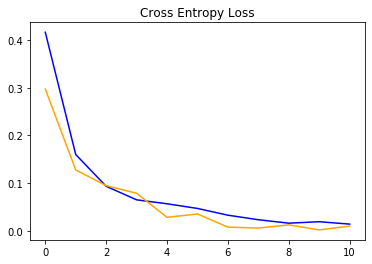

In [30]:

path1  = path+ '/Data/valplate'


ratio = 0.3
x_train = []
y_train = []
x_test = []
y_test = []
label = ''
for imgg in listdir(path1):
    img = cv.imread(path1+ '/'+imgg,1)
    img = cv.resize(img,(30,90))
    if(imgg[0]=='b'):
        label = 1
    else:
        label = 0
    if np.random.random()<ratio:
        x_test.append(img)
        y_test.append(label)
    else:
        x_train.append(img)
        y_train.append(label)
        
        
x_train = np.asarray(x_train)/255.0
x_test = np.asarray(x_test)/255.0

def define_model():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(90,30,3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same' ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (4, 4), activation='relu', padding='same' ))
    model.add(MaxPooling2D((3, 3)))
    model.add(Flatten())
    model.add(Dense(600, activation='relu'))
    model.add(Dense(600, activation='relu'))
    
 
  
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    pyplot.show()
    # plot accurac
#  the test harness for evaluating a model

model = define_model()
history = model.fit(x_train,y_train,epochs=11,verbose=1,validation_data=(x_test,y_test))
summarize_diagnostics(history)
model.save('model_valplate.h5')

Despues de cortadas las imagenes se añadiran a una de las carpetas (Entrenamiento o Validación) en ambos casos (Números y Letras), se tomaran el 70% de las imagenes para entrenamiento y el 30% para la validación. Como esta selección es aleatoria se adjuntara en la parte de archivos necesarios para el desarrollo de la maquina, las carpetas de la manera que nosotros obtuvimos con el fin de que se puedan reproducir los mismos resultados.

In [33]:
########## datos para training, val  y test

fold = path + '/Data/data_machine'
foldennum = path + '/Data/numeros'
foldenlet = path+'/Data/letras'
foldernum =  fold +'/numeros'
folderletr =  fold +'/letras'
listnum = listdir(foldernum)
listletr = listdir(folderletr)
ratio =  0.7

numTrain = []
numVal = []
TnumTrain = []
TnumVal = []


letTrain = []
letVal = []
TletTrain = []
TletVal = []


############ Números
for num in listnum:
   
    img = cv.imread(foldernum + '/'+num,1)
    img = cv.resize(img,(30,90))
    
   
    if random.random()<ratio:

        numTrain.append(np.array(img))
        TnumTrain.append(num[0])
        copyfile(foldernum+'/'+num, foldennum+'/trainin/'+num)

    else:

        numVal.append(np.array(img))
        TnumVal.append(num[0])
        copyfile(foldernum+'/'+num, foldennum+'/validation/'+num)
########### letras
        
for letr in listletr:
    
    img = cv.imread(folderletr + '/'+letr,1)
    
    img = cv.resize(img,(30,90))
    
    if random.random()<ratio:

        letTrain.append(np.array(img))
        TletTrain.append(letr[0])
        copyfile(folderletr+'/'+ letr, foldenlet+'/trainin/'+ letr)

    else:
        
        letVal.append(np.array(img))
        TletVal.append(letr[0])
        copyfile(folderletr+'/'+ letr, foldenlet+'/validation/'+ letr)
        
        
dir_cod = path + '/codigos'
makedirs(dir_cod+'/data_numpy/', exist_ok=True)
dir_numpy= path + '/codigos/data_numpy/'




In [34]:
print('Números')
print('numeros', len(listnum))

print('Training',len(numTrain))

print('Validation',len(numVal))


print('Letras')
print('letras', len(listletr))

print('Training',len(letTrain))
print('Validation',len(letVal))


numTrain = asarray(numTrain)
TnumTrain = asarray(TnumTrain)



numVal = asarray(numVal)
TnumVal  = asarray(TnumVal)

######## array  trainin test and validation  (NUM)

save(dir_numpy+'NumTrain.npy',numTrain)
save(dir_numpy+'labelNumTrain.npy', TnumTrain)



save(dir_numpy+'NumVal.npy',numVal)
save(dir_numpy+'labelNumVal.npy', TnumVal)



Números
numeros 1185
Training 856
Validation 329
Letras
letras 1195
Training 860
Validation 335


Posterior a esto guardamos como archivos numpy los array que contendran las imagenes y el label de la misma, asi mismo se tiene en cuenta los target de los números (0-9) y las letras (A-Z).

In [35]:
## Target de las letras a números 



TletVal = tarletr(TletVal,abc)

TletTrain = tarletr(TletTrain,abc)
letTrain = asarray(letTrain)
TletTrain = asarray(TletTrain)


letVal = asarray(letVal)
TletVal  = asarray(TletVal)

######## array  trainin test and validation (LET)
save(dir_numpy+'letTrain.npy',letTrain)
save(dir_numpy+'labelletTrain.npy', TletTrain)


save(dir_numpy+'letVal.npy',letVal)
save(dir_numpy+'labelletVal.npy', TletVal)

A continuación se hara la construcción de la maquina diseñada para los números la misma, tiene como entrada un tensor (90,30,3),el cual es el tamaño del tensor donde almacenamos las imagenes tanto para números y letras, la maquina es una red neuronal profunda, con 3 capas de convolución de tamaños 128,64 y 32 respectivamente, y dos capas densas cada una de 4400 neuronas  con función de activación RELU y el optimizador adam junto a la función de perdida Entropía cruzada (Varias Categorias), esta configuración de la red permite que tengamos una precisión de 95% en los 338 números que se usaron para validación y 99% aproximadamente en los 858 números que se usaron para el entrenamiento

In [36]:
###### Cargar array numpy 
pathnum=  path+'/codigos/data_numpy/'

trainL = np.load(pathnum+'labelNumTrain.npy')
train  = np.load(pathnum+'NumTrain.npy').reshape((trainL.size, 90, 30, 3))
valL = np.load(pathnum+'labelNumVal.npy')
val =  np.load(pathnum+'NumVal.npy').reshape((valL.size, 90, 30, 3))
train = train/255.0

val = val/255.0

In [37]:
def define_model():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(90,30,3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same' ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (4, 4), activation='relu', padding='same' ))
    model.add(MaxPooling2D((3, 3)))
    model.add(Flatten())
    model.add(Dense(4800, activation='relu'))
    model.add(Dense(4800, activation='relu'))
    
 
  
    model.add(Dense(10, activation='softmax'))
    # compile model
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
 
# plot diagnostic learning curves





In [38]:
 # define model
model = define_model()
history = model.fit(train,trainL,epochs=45,verbose=1,validation_data=(val,valL),batch_size=20,callbacks =[callbacks])


Train on 856 samples, validate on 329 samples
Epoch 1/45
856/856 [==============================] - 39s 45ms/sample - loss: 1.3905 - acc: 0.5164 - val_loss: 0.4564 - val_acc: 0.9058
Epoch 2/45
856/856 [==============================] - 36s 42ms/sample - loss: 0.2469 - acc: 0.9603 - val_loss: 0.2286 - val_acc: 0.9453
Epoch 3/45
856/856 [==============================] - 37s 43ms/sample - loss: 0.2002 - acc: 0.9673 - val_loss: 0.2287 - val_acc: 0.9574
Epoch 4/45
856/856 [==============================] - 36s 42ms/sample - loss: 0.1638 - acc: 0.9661 - val_loss: 0.2455 - val_acc: 0.9574
Epoch 5/45
856/856 [==============================] - 36s 42ms/sample - loss: 0.1295 - acc: 0.9778 - val_loss: 0.2669 - val_acc: 0.9635
Epoch 6/45
856/856 [==============================] - 35s 41ms/sample - loss: 0.1360 - acc: 0.9743 - val_loss: 0.2567 - val_acc: 0.9544
Epoch 7/45
856/856 [==============================] - 35s 41ms/sample - loss: 0.0934 - acc: 0.9801 - val_loss: 0.3532 - val_acc: 0.9422
Ep

In [39]:

model.save('model_num.h5')

A continuación se hara la construcción de la red neuronal profunda que se usara para hacer la identificación de las letras al igual que en la red usada para los números su entrada sera un tensor (90,30,3) donde estara almacenada la imagen de la letra luego de ser segmentada de la placa, para su identificación, la misma consta de tres convoluciones de tamaños 32,64 y 128 respectivamente y dos capas densas de tamaños 1600 todas con función de activación Relu a excepción de la ultima capa que es Softmax, junto al optimizador adam que usa como función de perdida entropía cruzada (Con varias categorias).

In [40]:
trainL = np.load(pathnum+'labelletTrain.npy')

train  = np.load(pathnum+'letTrain.npy').reshape((trainL.size, 90, 30, 3))

valL = np.load(pathnum+'labelletVal.npy')

val =  np.load(pathnum+'letVal.npy').reshape((valL.size, 90, 30, 3))



def define_model():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(90,30,3)))
    model.add(MaxPooling2D((2, 2)))
    
 
    model.add(Conv2D(64, (3,3), activation='relu', padding='same' ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same' ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1800, activation='relu'))
    model.add(Dense(1800, activation='relu'))
    

  
    model.add(Dense(27, activation='softmax'))
    # compile model
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    #pyplot.subplot(212)
    #pyplot.title('Classification Accuracy')
    #pyplot.plot(history.history['accuracy'], color='blue', label='train')
    #pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.show()

#  the test harness for evaluating a model

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs={}):
        if (logs.get('acc')>0.99 and logs.get('val_acc')>0.98):
            print("\lnReached 99% accuracy, so canceling training!")
            self.model.stop_training=True 
            
callbacks = myCallback()         
model = define_model()
history = model.fit(train,trainL,epochs=10,verbose=1,validation_data=(val,valL),callbacks =[callbacks]) 




Train on 860 samples, validate on 335 samples
Epoch 1/10
860/860 [==============================] - 18s 21ms/sample - loss: 11.8454 - acc: 0.4791 - val_loss: 0.3037 - val_acc: 0.9522
Epoch 2/10
860/860 [==============================] - 17s 19ms/sample - loss: 0.1381 - acc: 0.9744 - val_loss: 0.0223 - val_acc: 0.9940
Epoch 3/10
860/860 [==============================] - 16s 19ms/sample - loss: 0.0170 - acc: 0.9953 - val_loss: 0.1135 - val_acc: 0.9881


In [41]:

model.save('model_let.h5')

In [42]:
num_model = tf.keras.models.load_model('model_num.h5')
let_model =tf.keras.models.load_model('model_let.h5')
valplate_model = tf.keras.models.load_model('model_valplate.h5')


Posteriormente a tener entrenadas las tres redes neuronales, teniendo con una precisión en validación de aproximadamente el 95%  y guardarlas,se procedera a hacer la validación de una placa completa, esto consistira en hacer el recorte de una placa al azar, en la cual cada uno de las letras y números que fueron recortados de la misma se introduciran, a la maquina que nos indicara si quedaron bien o mal recortados, este procedimiento es bastante importante puesto que en caso de que el recorte nos indique que esta mal sera más complicado tanto para la maquina de números y letras hacer una predicción confiable del elemento que se ingreso, despues de que los recortes pasaran por la red que nos indica si estan bien o mal recortados, los mismos se introduciran en la maquina de letras o números, de acuerdo al cual corresponda, en las placas que estamos usando en todo el proceso se constituyen de la misma manera y es (Número,Letra,Número,Número,Número,Número,Número), por ejemplo 1A1111, por lo tanto ese sera el patrón que nos indicara en que orden deben ser usadas las redes de Números y Letras. 

In [16]:
foldata =  path + '/Data/datos/' #carpeta donde se enviaran las placas que van a validación 
foldval =  path + '/Data/validation_pla' #Carpeta donde se encuentran las placas 

In [43]:

# ubicación de la carpeta del proyecto 

ratio = 0.9

for fol in listdir(foldata):
    folh =  foldata+ fol
    for ima in listdir(folh):
        if np.random.random()<ratio:
            trackid = './'+fol+'/'+ima 
            tar = list(datos[(datos['image_path']==trackid)]['lp'])[0]
            copyfile(folh+'/'+ima,foldval+'/' +tar+'.PNG')



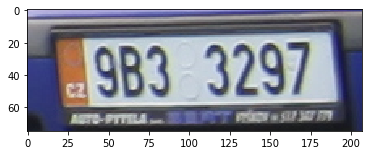

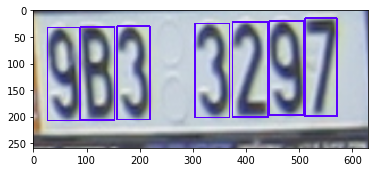

Prediccion de la placa:   9B33297


In [64]:
imgpth =listdir(foldval)[1]

imgg = cv.imread(foldval+'/'+imgpth,0) 
imgg1 = cv.imread(foldval+'/'+imgpth,1) 

plt.imshow(imgg1)
plt.show()
val_img(imgg,imgg1)

In [65]:


##### ACC real 
acc =acc_val(foldval)
print('Número de placas: ' + str(len( listdir(foldval))))
print('Acc :    ' +str(acc[0]))
print('Placas mal segmentadas:'+ str(acc[1]))

Número de placas: 152
Acc :    0.9098360655737705
Placas mal segmentadas:30


Al final tendremos una precisión "real", que es predecir toda la placa, esto debido a que asi se llegara al 95% en precisión tanto en la red de números y de letras, si en una placa falla al menos un número o su letra, esta placa se tomara como mal clasificada,adicional a esto tendremos el número de placas que la red detecto como mal segmentadas en todo el conjunto de Test, esta mal segmentación puede deberse a la inclinación que tiene la placa y que no permite hacer la segmentación de manera sencilla, esto daria como resultado que para estas placas se deberia tomar una segmentación practicamente personalizada para cada una, como una gran mejora a este proyecto creemos que la posición de donde se toma la foto a la placa es la parte más importante para hacer su identificación por lo tanto, si se tomaran imagenes tomadas por una misma camara y en una misma posición por ejemplo (Centros Comerciales, Conjuntos Residenciales, etc), se lograria llegar a una precisión más alta de la identificación.  